# Bayesian analysis of coronavirus data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import stats
from scipy.optimize import minimize
import emcee
import pymc3 as pm
import numdifftools as nd

In [3]:
global_confirmed = pd.read_csv('/Users/kulkarniad/covid/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
global_deaths = pd.read_csv('/Users/kulkarniad/covid/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
global_recovered = pd.read_csv('/Users/kulkarniad/covid/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

us_confirmed = pd.read_csv('/Users/kulkarniad/covid/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
us_deaths = pd.read_csv('/Users/kulkarniad/covid/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

In [4]:
def get_us_data(state):
    df = us_confirmed[us_confirmed['Province_State'] == state]
    confirmed = df.sum(axis=0)
    confirmed = confirmed[11:]  # skip metadata
    confirmed = pd.DataFrame(confirmed,columns=['confirmed'])
    
    df = us_deaths[us_deaths['Province_State'] == state]
    deaths = df.sum(axis=0)
    deaths = deaths[12:]  # skip metadata
    deaths = pd.DataFrame(deaths,columns=['deaths'])

    return pd.concat([confirmed,deaths], axis=1)

def get_data(country):
    df = global_confirmed[global_confirmed['Country/Region'] == country]
    confirmed = df.sum(axis=0)
    confirmed = confirmed[4:]  # skip metadata
    confirmed = pd.DataFrame(confirmed,columns=['confirmed'])
    
    df = global_deaths[global_deaths['Country/Region'] == country]
    deaths = df.sum(axis=0)
    deaths = deaths[4:]  # skip metadata
    deaths = pd.DataFrame(deaths,columns=['deaths'])

    df = global_recovered[global_recovered['Country/Region'] == country]
    recovered = df.sum(axis=0)
    recovered = recovered[4:]  # skip metadata
    recovered = pd.DataFrame(recovered,columns=['recovered'])
    
    return pd.concat([confirmed, recovered,deaths], axis=1)


# Start out with a simple model

$\frac{dI}{dt} = (R_0\frac{S}{N} - 1)\gamma t$ 

Initially, $S \approx N$

$\frac{dI}{dt} = (R_0 - 1)\gamma t$ 

$I \sim e^{(R_0 - 1)\gamma t}$ 



In [124]:
#state_index = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')
#state_index = state_index.iloc[:,0:2]

In [159]:
class Analyze:
    def __init__(self,state,t_cut):
        self.state = state
        self.t_cut = t_cut
    
    def state_code(self):
        return state_index[state_index.state == self.state].code.values[0]
    
    def get_data(self):
        cases = get_us_data(self.state).confirmed.to_numpy(dtype = 'float64')
        self.obs_cases = np.trim_zeros(cases)[:self.t_cut] # keep only t_cut days
        self.time = np.arange(self.t_cut)
    
    def mcmc(self,samples = 1000):
        self.get_data()
        
        with pm.Model() as linear_model:
            # log normal priors for slope and intercept
            slope = pm.Lognormal('slope',mu=0.0,sigma = 1)
            intercept = pm.Lognormal('intercept',mu=0,sigma = 1)
            sigma = pm.Lognormal('sigma',mu=0, sigma=1)
            
            #Normal likelihood (on log scale) for number of cases
            cases = pm.Normal('cases',intercept + slope*self.time,observed = np.log(self.obs_cases))
            samples = pm.sample(draws=1000)
            r0 = samples.get_values('slope')/gamma + 1
            self.meanr0 = np.mean(r0)
            self.hpdr0 = pm.hpd(r0)
            return samples
    
    
    def make_plots(self,samples):
        r0 = samples.get_values('slope')/gamma + 1
        plt.hist(r0,bins=30,density=True,color='red',alpha = 0.2)
        plt.hist(r0,bins=30,density=True,color='black',histtype='step')

        plt.title('Histogram of R0',fontsize = 30)
        plt.xlabel('R0',fontsize = 20)
        plt.show()
        
        slp = samples.get_values('slope')
        incp = samples.get_values('intercept')
        
        for i in range(1000):
            plt.semilogy(self.time,np.e**(self.time*slp[i] + incp[i]),alpha = 0.01,color = 'black')
        
        plt.semilogy(self.time,self.obs_cases,color = 'red',linewidth = 2)
        plt.xlabel('time (days)',fontsize=20)
        plt.ylabel('confirmed cases',fontsize=20)
        plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:07<00:00, 811.42draws/s] 


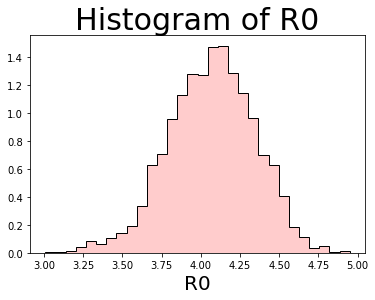

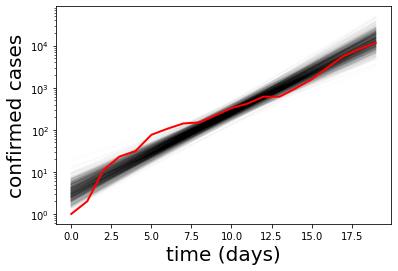

In [193]:
gamma = 1/7  # assume it takes a week to recover from corona(https://www.hopkinsmedicine.org/health/conditions-and-diseases/coronavirus/diagnosed-with-covid-19-what-to-expect)
state = Analyze('New York',20)

samples = state.mcmc()
state.make_plots(samples)


In [39]:
def estimate_r0(code,days=20):
    state_name = state_index[state_index.code == code].state.values[0]
    state = Analyze(state_name,days)
    samples = state.mcmc()
    return state.meanr0

r0_list = []
for state in state_index.code.values:
    r0_list.append(estimate_r0(state,20))
state_index['meanR0'] = r0_list
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:03<00:00, 1940.21draws/s]
The acceptance probability does not match the target. It is 0.8799216094235285, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.879814789370503, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2283.47draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [

Sampling 4 chains, 1 divergences: 100%|██████████| 6000/6000 [00:05<00:00, 1065.56draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8891973453253779, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1323.68draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]
Sampling 4 chains, 2 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1356.13draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...

In [41]:
cfr_list = []
for state in state_index.code.values:
    state_name = state_index[state_index.code == state].state.values[0]
    cfr = get_us_data(state_name).deaths[-1]/get_us_data(state_name).confirmed[-1]
    cfr_list.append(cfr)
state_index['CFR'] = cfr_list


In [12]:
# Load pkl file
state_index = pd.read_pickle("state_r0_cfr.pkl")

In [194]:
import plotly.graph_objects as go
# Load data frame and tidy it.
import pandas as pd

fig = go.Figure(data=go.Choropleth(
    locations=state_index['code'], # Spatial coordinates
    z = state_index['meanR0'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "R0",
))

fig.update_layout(
    title_text = 'Covid-19 R0 estimates by state',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [422]:
#plt.semilogy(us_confirmed[us_confirmed.Province_State == 'Washington'].sum(axis = 0)[11:],label = 'Washington')
#plt.semilogy(us_confirmed[us_confirmed.Province_State == 'New York'].sum(axis = 0)[11:],label = 'New York')
#plt.semilogy(us_confirmed[us_confirmed.Province_State == 'Colorado'].sum(axis = 0)[11:],label = 'Colorado')

#plt.legend()

# Fun model but doesnt allow us to make predictions... (Linear model doesnt die out). Let's see what a SIR model gives us:

# Fit Colorado data


In [20]:
# Let's fit colorado data
country = get_us_data('Colorado')
time = np.arange(len(country))
N = 5.759e6

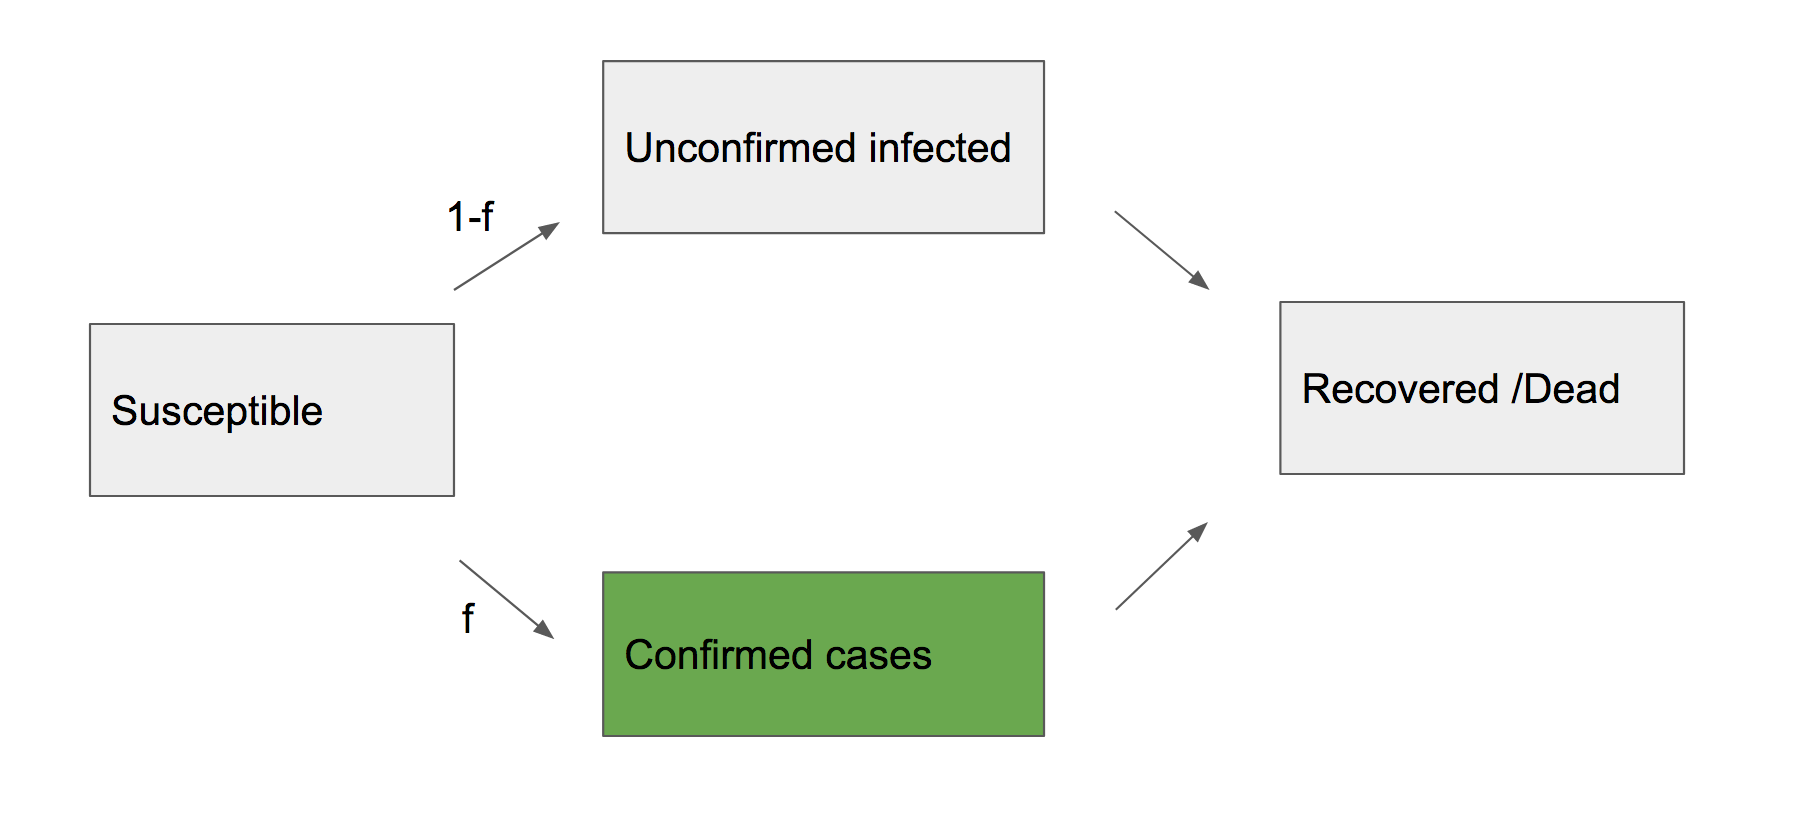

In [21]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "model.png",width = 900)

In [164]:
# N is fixed
# I_0 can be variable

def SIR(t,y,beta,gamma,f):
    S = y[0]
    Ic = y[1]
    Iuc = y[2]
    R = y[3]
    
    S_flux = -beta*S*(Ic + Iuc)/N  # = ds/dt
    I_flux = (beta*S*(Ic + Iuc)/N - gamma*(Ic + Iuc)) # total infected flux
    
    # only a fraction of infected people get confirmed
    Ic_flux = f*I_flux
    Iuc_flux = (1-f)*I_flux
    
    # both reported and unreported people recover
    R_flux = gamma*(Ic + Iuc)
    
    return([S_flux, Ic_flux,Iuc_flux, R_flux])


In [147]:
def positive_check(x):
    # check to ensure all params >= 0
    return np.all(x >= 0)
    

def solve_ode(params):
    if not positive_check(params):
        return np.zeros(len(time)) + np.inf
    
    else:
        Iuc0,beta,gamma,f = params
        
        Ic0 = country.confirmed.values[0]
        S0 = N - (Ic0 + Iuc0)
        R0 = 0

        y0 = [S0,Ic0,Iuc0,R0]

        sol = solve_ivp(SIR,[0,100],y0,args=(beta,gamma,f),dense_output=True)

        confirmed = np.cumsum(sol.sol(time)[1])

        if positive_check(confirmed):
            return confirmed
        else:
            return np.zeros(len(time)) + np.inf  
    
def sse(params):  # sum of squared errors on log scale
    data = country.confirmed.values.astype('float64')
    model = solve_ode(params)

    errors = (np.log(data+0.1) - np.log(model+0.1))**2
    return np.sum(errors)

def log_like(params):
    data = country.confirmed.values.astype('float64') + 0.1
    model = solve_ode(params) + 0.1
    
    if np.any(model == np.inf):
        return (np.inf)*(-1.0)
    else:
        likehood = stats.norm.logpdf(data, model, np.sqrt(model))  # x, mean, scale
        return np.sum(likehood)

def nll(params):
    return log_like(params) * (-1.0)

def log_prior(params):
    Iuc0,b,gamma,f = params
    prior = 0
    
    # we know from above, R0 is approximately 3
    prior += stats.norm.logpdf(b/gamma,3,0.2)

    # again apprxoimately 1 week to recover
    prior += stats.norm.logpdf(gamma,0.14,0.4)
    return prior
    

def log_posterior(params):
    return log_like(params) + log_prior(params)

def nlp(params):
    return (-1.0 * log_posterior(params))

def view_plot(params,alpha=0.5,color='black'):
    confirmed = solve_ode(params)
    plt.plot(confirmed, alpha=alpha,color = color)
    

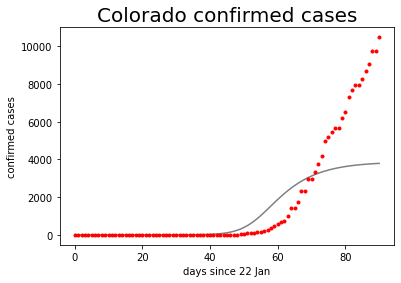

In [196]:
Iuc0 = 1
b = 3*0.14
gamma = 0.14
f = 0.0001 #f needs to be small to get a good fit...

plt.title('Colorado confirmed cases',fontsize = 20)
view_plot(np.array([Iuc0,b,gamma,f]))
plt.plot(time,country.confirmed,'ro',markersize = 3)
plt.xlabel('days since 22 Jan')
plt.ylabel('confirmed cases')
locs, labels = plt.yticks()   

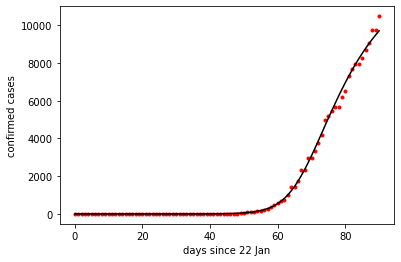

MAP estimates:
Initial unconfirmed cases  	| 0.4390698901435245
beta  				| 0.3111840453618152
gamma unconfirmed cases  	| 0.07042399508193192
Fraction testing  		| 0.00016035068822079429
R0  				| 4.418721843311798


In [199]:
# Minimize negative log likelihood to find MAP
opt = minimize(nlp,[Iuc0,b,gamma,f],method='Nelder-Mead')
plt.plot(time,country.confirmed,'ro',markersize = 3)
view_plot(opt.x,alpha=1)

plt.xlabel('days since 22 Jan')
plt.ylabel('confirmed cases')
plt.show()

print('MAP estimates:')
print('Initial unconfirmed cases  \t|',opt.x[0])
print('beta  \t\t\t\t|',opt.x[1])
print('gamma unconfirmed cases  \t|',opt.x[2])
print('Fraction testing  \t\t|',opt.x[3])
print('R0  \t\t\t\t|',opt.x[1]/opt.x[2])


# Now do an MCMC sample of the full posterior

In [181]:
cov = (np.diagflat(opt.x)/10)**2

In [138]:
p0 = np.random.multivariate_normal(opt.x,cov,size = 30)

In [68]:
import emcee

ndim, nwalkers = 4, 30

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
output = sampler.run_mcmc(p0,100,store=True)


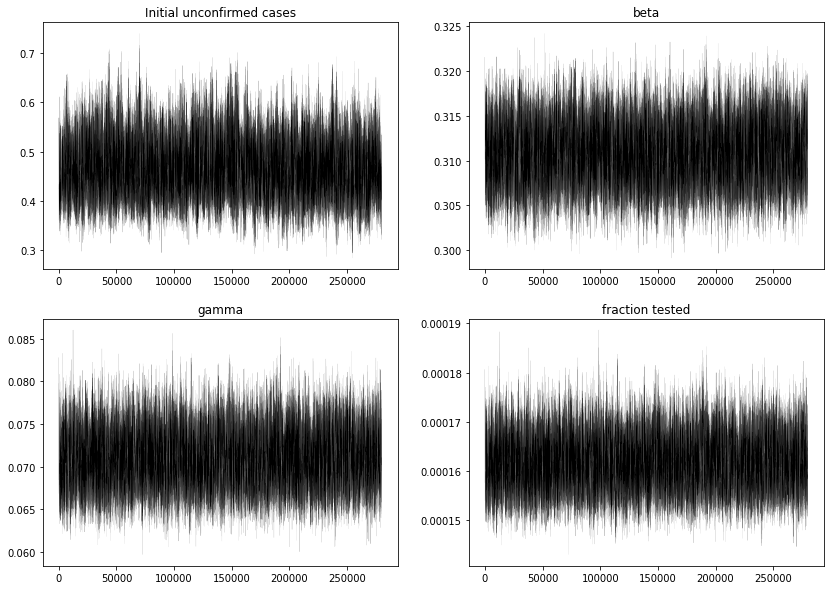

In [200]:
#chain = np.load('big_SIR.npy')
chain = np.load('colorado_SIR_BIG.npy').reshape(-1,4)

chain = chain[20000:,:]
plt.figure(figsize=(14,10))
plt.subplot(221)
plt.title('Initial unconfirmed cases')
plt.plot(chain[:,0],color = 'black',linewidth = 0.05)
plt.subplot(222)
plt.title('beta')
plt.plot(chain[:,1],color = 'black',linewidth = 0.05)
plt.subplot(223)
plt.title('gamma')
plt.plot(chain[:,2],color = 'black',linewidth = 0.05)
plt.subplot(224)
plt.title('fraction tested')
plt.plot(chain[:,3],color = 'black',linewidth = 0.05)
plt.show()



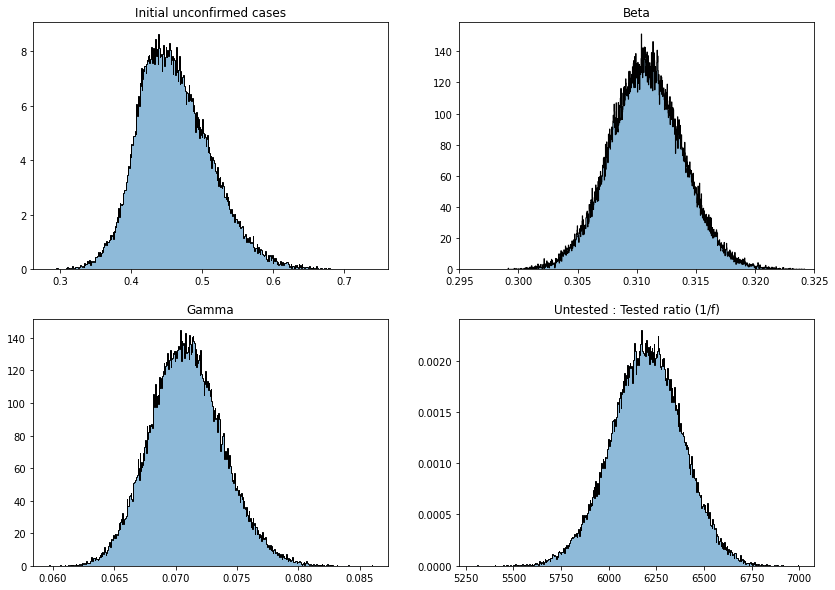

In [155]:
plt.figure(figsize=(14,10))
plt.subplot(221)
plt.title('Initial unconfirmed cases')
plt.hist(chain[:,0],bins=500,alpha = 0.5,density=True)
plt.hist(chain[:,0],bins=500,color = 'black',density=True,histtype='step')

plt.subplot(222)
plt.title('Beta')
plt.hist(chain[:,1],bins=1000,alpha = 0.5,density=True)
plt.hist(chain[:,1],bins=1000,color = 'black',density=True,histtype='step')
plt.xlim(0.295,0.325)

plt.subplot(223)
plt.title('Gamma')
plt.hist(chain[:,2],bins=500,alpha = 0.5,density=True)
plt.hist(chain[:,2],bins=500,color = 'black',density=True,histtype='step')

plt.subplot(224)
plt.title('Untested : Tested ratio (1/f)')
plt.hist(1/chain[:,3],bins=500,alpha = 0.5,density=True)
plt.hist(1/chain[:,3],bins=500,color = 'black',density=True,histtype='step')
plt.show()


### let's see what we can learn about this:

Our information contains information about the the contact and recovery timescales...

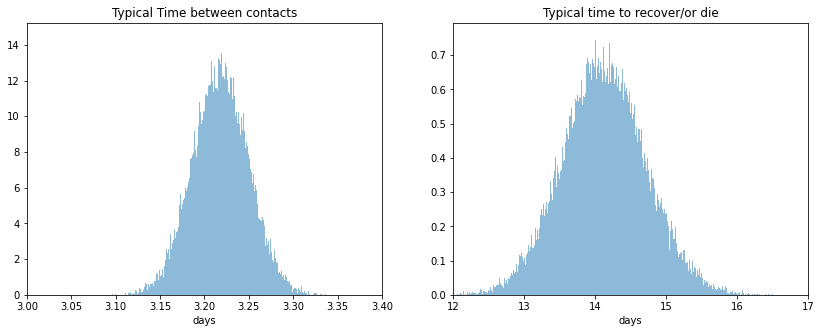

In [30]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.title('Typical Time between contacts')
plt.hist(1/chain[:,1],bins=1000,alpha = 0.5,density=True)
plt.xlim(3.0,3.4)
plt.xlabel('days')

plt.subplot(122)
plt.title('Typical time to recover/or die')
plt.hist(1/chain[:,2],bins=1000,alpha = 0.5,density=True)
plt.xlim(12,17)
plt.xlabel('days')

plt.show()

#### Pretty interesting...
I'm not a doctor but with some help from bayes I can estimate how long it takes people to recover from corona

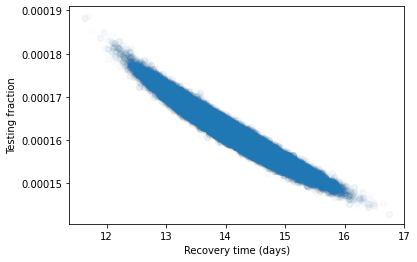

In [72]:
# There are also some interesting corrleations in our dataset
plt.scatter(1/chain[:,2],chain[:,3],alpha=0.01)
plt.xlabel('Recovery time (days)')
plt.ylabel('Testing fraction')
plt.show()

In [32]:
chain.shape

(280000, 4)

# Where are we now ?

## Need posterior predictive distributions

In [114]:
def extrapolate(params,tmax = 300):
    Iuc0,beta,gamma,f = params

    Ic0 = country.confirmed.values[0]
    S0 = N - (Ic0 + Iuc0)
    R0 = 0

    y0 = [S0,Ic0,Iuc0,R0]

    sol = solve_ivp(SIR,[0,tmax],y0,args=(beta,gamma,f),dense_output=True)
    
    #susceptible = sol.sol(np.arange(tmax))[0]
    confirmed = np.cumsum(sol.sol(np.arange(tmax))[1])
    
    for i in range(len(confirmed)):
        noise = np.random.normal()* np.sqrt(confirmed[i])
        confirmed[i] += noise
    
    #unconfirmed = np.cumsum(sol.sol(np.arange(tmax))[2])
    #recovered = sol.sol(np.arange(tmax))[3]
    return confirmed


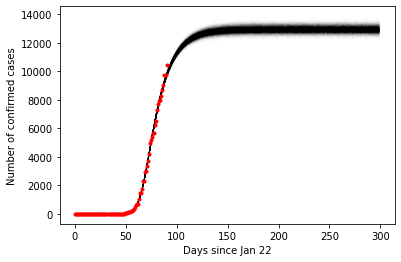

In [115]:
for i in range(1000):
    plt.plot(extrapolate(chain[np.random.randint(len(chain))]),alpha = 0.005,color='black')
plt.plot(country.confirmed.values,'ro',markersize = '3')
plt.ylabel('Number of confirmed cases')
plt.xlabel('Days since Jan 22')
plt.show()



### According to this model, things should be clearing up in the next 10 - 20 days...

How many people are going to die in total?

Case fatality rate = dead / Confirmed infected

In [201]:
print('We are at',country.deaths[-1],'deaths')
print('We are at',country.confirmed[-1],'confirmed cases')

We are at 483 deaths
We are at 10473 confirmed cases


In [157]:
cfr = np.random.poisson(country.deaths[-1],size = 1000)/np.random.poisson(country.confirmed[-1],size = 1000)

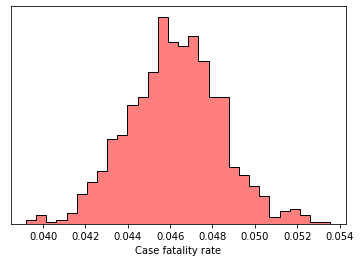

In [172]:
plt.hist(cfr,bins=30,alpha = 0.5,color = 'red',density=True)
plt.hist(cfr,bins=30,color = 'black',histtype='step',density=True)
plt.xlabel('Case fatality rate')
plt.yticks([])
plt.show()

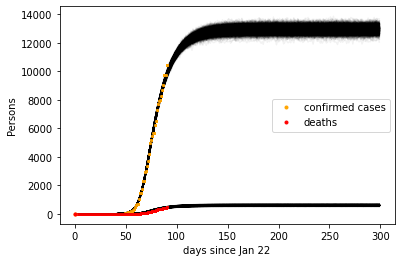

In [119]:
death_list = []
for i in range(1000):
    loc = np.random.randint(len(chain))
    confirmed = extrapolate(chain[loc])
    deaths = confirmed * cfr[i]
    death_list.append(deaths)
    
    plt.plot(country.confirmed.values,'o',color = 'orange',markersize = 1,alpha = 1)
    plt.plot(country.deaths.values,'ro',markersize = 2,alpha = 1)
    plt.plot(confirmed,alpha = 0.05,color = 'black')
    plt.plot(deaths,alpha = 0.05,color = 'black')
    
plt.xlabel('days since Jan 22')
plt.ylabel('Persons')
plt.plot([0],'o',color = 'orange',markersize = 3,alpha = 1,label = 'confirmed cases')
plt.plot([0],'ro',markersize = 3,alpha = 1,label = 'deaths')
plt.legend()
plt.show()


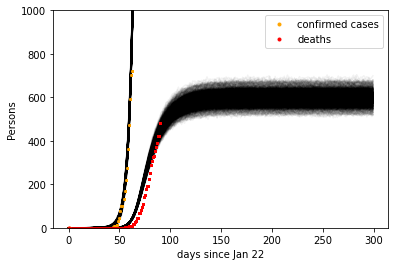

In [120]:
death_list = []
for i in range(1000):
    loc = np.random.randint(len(chain))
    confirmed = extrapolate(chain[loc])
    deaths = confirmed * cfr[i]
    death_list.append(deaths)
    
    plt.plot(country.confirmed.values,'o',color = 'orange',markersize = 1,alpha = 1)
    plt.plot(country.deaths.values,'ro',markersize = 2,alpha = 1)
    plt.plot(confirmed,alpha = 0.05,color = 'black')
    plt.plot(deaths,alpha = 0.05,color = 'black')
plt.ylim(0,1000)
plt.xlabel('days since Jan 22')
plt.ylabel('Persons')
plt.plot([0],'o',color = 'orange',markersize = 3,alpha = 1,label = 'confirmed cases')
plt.plot([0],'ro',markersize = 3,alpha = 1,label = 'deaths')
plt.legend()
plt.show()

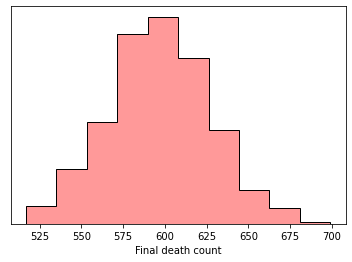

In [170]:
plt.hist(np.array(death_list)[:,-1],color = 'red',alpha = 0.4)
plt.hist(np.array(death_list)[:,-1],color = 'black',histtype = 'step')
plt.xlabel('Final death count')
plt.yticks([])
plt.show()